### Visualizing Geospatial data
- polygons and scatterplots 
- creating and joining geoDataFrame
- geoseries and forlium
- choropleth 

In [19]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import folium

                   name                                           geometry
0  Historic Buena Vista  MULTIPOLYGON (((-86.79511 36.17576, -86.79403 ...
1        Charlotte Park  MULTIPOLYGON (((-86.87460 36.15758, -86.87317 ...
2              Hillwood  MULTIPOLYGON (((-86.87614 36.13554, -86.87583 ...
3            West Meade  MULTIPOLYGON (((-86.90384 36.12554, -86.90328 ...
4          White Bridge  MULTIPOLYGON (((-86.86321 36.12886, -86.86321 ...


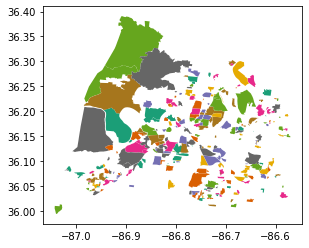

In [2]:
# Read in the neighborhoods geojson file
neighborhoods = gpd.read_file('neighborhoods.geojson')

# Print the first few rows of neighborhoods
print(neighborhoods.head())

# Plot the neighborhoods, color according to name and use the Dark2 colormap
neighborhoods.plot(column = 'name', cmap = 'Dark2')

# Show the plot.
plt.show()

### Coordinate Reference Systems
You can change the coordinate reference system of a GeoDataFrame by changing the crs property of the GeoDataFrame. 

Notice that the units for geometry change when you change the CRS. 
- EPSG: 4326: decimal degrees for distance
- EPSG: 3857: meters

In [3]:
school_districts = gpd.read_file('school_districts.geojson')

In [4]:
print(school_districts.head(1))
print(school_districts.crs)

   first_name       city    zip                           email state  \
0  Dr. Sharon  Nashville  37218  gentryfordistrict1@comcast.net    TN   

  last_name          address position term_expir district         phone  \
0    Gentry  6108 Beals Lane   Member       2016        1  615-268-5269   

                                            geometry  
0  MULTIPOLYGON (((-86.77136 36.38357, -86.77134 ...  
epsg:4326


In [5]:
# Convert the crs to epsg:3857
school_districts.geometry = school_districts.geometry.to_crs(epsg = 3857)              
# Print the first row of school districts GeoDataFrame and the crs again
print(school_districts.head(1))
print(school_districts.crs)

   first_name       city    zip                           email state  \
0  Dr. Sharon  Nashville  37218  gentryfordistrict1@comcast.net    TN   

  last_name          address position term_expir district         phone  \
0    Gentry  6108 Beals Lane   Member       2016        1  615-268-5269   

                                            geometry  
0  MULTIPOLYGON (((-9659344.056 4353528.767, -965...  
epsg:3857


### Creating a geometry column

In [184]:
# Print the first few rows of the art DataFrame
art= pd.read_csv('public_art.csv')

# Create a geometry column from lng & lat
art['geometry'] = art.apply(lambda x: Point(float(x.Longitude), float(x.Latitude)), axis=1)

# Create a GeoDataFrame from art and verify the type
art_geo = gpd.GeoDataFrame(art, crs = neighborhoods.crs, geometry = art.geometry)
print(type(art_geo['geometry']))

<class 'geopandas.geoseries.GeoSeries'>


Now that the public art data is in a GeoDataFrame we can join it to the neighborhoods with a special kind of join called a spatial join. Let's go learn about how that's done!
- contains
- intersects
- within
Spatial join
- rtree and libspatialindex (brew install spatialindex -mac) need to be installed 

In [9]:
# Create art_within_neighborhoods by spatially joining art_geo and neighborhoods
art_intersect_neighborhoods = gpd.sjoin(art_geo, neighborhoods, op = 'within')

# Print the shape property of art_within_neighborhoods
print(art_intersect_neighborhoods.shape)


(40, 13)


In [ ]:
# Spatially join art_geo and neighborhoods 
art_intersect_neighborhoods = gpd.sjoin(art_geo, neighborhoods, op = 'intersects')

# Print the shape property of art_intersect_neighborhoods
print(art_intersect_neighborhoods.shape)


In [11]:
art_containing_neighborhoods = gpd.sjoin(art_geo, neighborhoods, op = 'contains')

# Print the shape property of art_containing_neighborhoods
print(art_containing_neighborhoods.shape)

(0, 13)


In [12]:
# Spatially join neighborhoods with art_geo
neighborhood_art = gpd.sjoin(art_geo, neighborhoods, op = "within")
# Print the first few rows
print(neighborhood_art.head())

                                Title Last Name First Name  \
1     [Fourth and Commerce Sculpture]    Walker        Lin   
4                A Story of Nashville    Ridley       Greg   
21                        Chet Atkins     Faxon    Russell   
22  Children's Chairs For The Seasons    McGraw     Deloss   
34                    Foliated Scroll   Bloomer       Kent   

                                             Location  \
1                   333 Commerce Street, Nashville TN   
4                     615 Church Street, Nashville TN   
21  Corner of Fifth Avenue North and Union Street,...   
22                    615 Church Street, Nashville TN   
34                    615 Church Street, Nashville TN   

                                         Medium       Type  \
1                                           NaN  Sculpture   
4                      Hammered copper repousse     Frieze   
21  Bronze stool and guitar on a granite plynth  Sculpture   
22                 Mixed Media - woo

Group, aggregate, and sort the data to find which neighborhood has the most public art. You can count artwork titles to see how many artworks are in each neighborhood.

In [18]:
# Get name and title from neighborhood_art and group by name
neighborhood_art_grouped = neighborhood_art[['name', 'Title']].groupby('name')

# Aggregate the grouped data and count the artworks within each polygon
print(neighborhood_art_grouped.agg('count').sort_values(by = 'Title', ascending = False))

                          Title
name                           
Urban Residents              22
Lockeland Springs             3
Edgehill (ONE)                2
Germantown                    2
Hillsboro-West End            2
Inglewood                     2
Sunnyside                     2
Chestnut Hill (TAG)           1
Historic Edgefield            1
McFerrin Park                 1
Renraw                        1
Wedgewood Houston (SNAP)      1


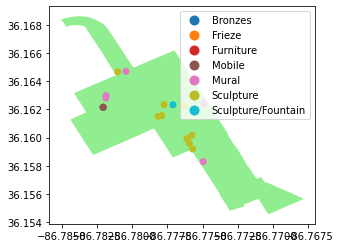

In [22]:
# Create urban_art from neighborhood_art where the neighborhood name is Urban Residents
urban_art = neighborhood_art.loc[neighborhood_art.name == 'Urban Residents']

# Get just the Urban Residents neighborhood polygon and save it as urban_polygon
urban_polygon = neighborhoods.loc[neighborhoods.name == "Urban Residents"]

# Plot the urban_polygon as ax 
ax = urban_polygon.plot(color = 'lightgreen')

# Add a plot of the urban_art and show it
urban_art.plot(ax = ax, column = 'Type', legend = True);
plt.show()

GeoSeries attributes and methods
- GeoSeries.area: returns the area of each geometry in a GeoSeries
- GeoSeries.centeroid: returns the center point of each geometry in a GeoSeries
- GeoSeries.distance(other): returns the minimum distance to other

In [26]:
print(school_districts.crs)
#define a variable for m^2 to km^2
sqm_to_sqkm = 10**6

district_area = school_districts.geometry.area / sqm_to_sqkm
print(district_area.sort_values(ascending = False))


epsg:3857
0    563.134380
4    353.232132
8    230.135653
1    218.369949
3    216.871511
5    164.137548
2    127.615396
7    119.742279
6     98.469632
dtype: float64


In [173]:
school_districts.geometry.area

0    0.036641
1    0.014205
2    0.008328
3    0.014123
4    0.023030
5    0.010704
6    0.006415
7    0.007813
8    0.015004
dtype: float64

In [50]:
school_districts = gpd.read_file('school_districts.geojson')
school_districts['center'] = school_districts.geometry.centroid

In [51]:
part = ['district','center']
school_district_centers = school_districts[part]
school_district_centers.head()

,district,center
0,1,POINT (-86.86087 36.26282)
1,3,POINT (-86.72361 36.28516)
2,2,POINT (-86.70156 36.03021)
3,4,POINT (-86.63964 36.19697)
4,9,POINT (-86.95428 36.10392)


In [52]:
district_one = school_districts.loc[school_districts.district == '1']
district_one.head()

,first_name,city,zip,email,state,last_name,address,position,term_expir,district,phone,geometry,center
0,Dr. Sharon,Nashville,37218,gentryfordistrict1@comcast.net,TN,Gentry,6108 Beals Lane,Member,2016,1,615-268-5269,"MULTIPOLYGON (((-86.77136 36.38357, -86.77134 ...",POINT (-86.86087 36.26282)


In [89]:
schools = pd.read_csv('schools.csv')
#create geometry in schools
schools['geometry'] = schools.apply(lambda x : Point((x.Longitude,x.Latitude)),axis=1)
s_crs = district_one.crs
print(s_crs)
schools_geo = gpd.GeoDataFrame(schools,crs=s_crs,geometry = schools.geometry)
#spatial join schools within dist 1
schools_in_dist1 = gpd.sjoin(schools_geo,district_one,op='within')
schools_in_dist1.shape

epsg:4326


(30, 30)

In [55]:
import pprint

distances = {}
for row in schools_in_dist1.iterrows():
    vals = row[1]
    key = vals['School Name']
    ctr = vals['center']
    distances[key] = vals['geometry'].distance(ctr)
pprint.pprint(distances)

{'Alex Green Elementary': 0.030287172719682773,
 'Bellshire Elementary': 0.0988045140909651,
 'Brick Church College Prep': 0.08961013862715599,
 'Buena Vista Elementary': 0.10570511270825833,
 'Cockrill Elementary': 0.1077685612196105,
 'Creswell Middle Prep School of the Arts': 0.07071695528308394,
 'Cumberland Elementary': 0.05107245423888074,
 'Haynes Middle': 0.09051735342452247,
 'Hull-Jackson Elementary': 0.09021711911422044,
 'Ivanetta H. Davis Learning Center at Bordeaux': 0.07662457433119775,
 'Joelton Elementary': 0.053341968112843634,
 'Joelton Middle': 0.05125961450823257,
 'John Early Middle': 0.09422796012374718,
 'Jones Elementary': 0.10102567625424698,
 'KIPP Nashville College Prep': 0.06251427354823408,
 'KIPP Nashville College Prep Elementary': 0.062254750966657696,
 'Moses McKissack Middle': 0.10691030507945888,
 'Nashville Academy of Computer Science': 0.08320287768739988,
 'Nashville Prep': 0.10066854450222189,
 'Purpose Prep': 0.0952621018938427,
 'RePublic High S

In [58]:
urban_polygon.geometry = urban_polygon.geometry.to_crs(epsg = 3857)

<class 'geopandas.geoseries.GeoSeries'>


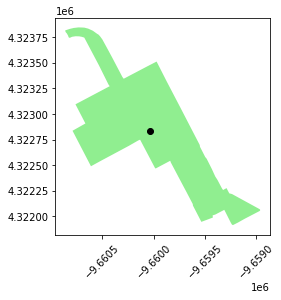

In [59]:
# Create downtown_center from urban_poly_3857
downtown_center = urban_polygon.geometry.centroid

# Print the type of downtown_center 
print(type(downtown_center))

# Plot the urban_poly_3857 as ax and add the center point
ax = urban_polygon.plot(color = 'lightgreen')
downtown_center.plot(ax = ax, color = 'black')
plt.xticks(rotation = 45)

# Show the plot
plt.show()

In [70]:
district_one.head()
center_point = district_one.center[0]
#reverse the order for folium location array
district_center = [center_point.y,center_point.x]
print(center_point)
print(district_center)

POINT (-86.86086595994405 36.2628221811899)
[36.262822181189904, -86.86086595994405]


In [78]:
#create a folium map centered on district 1
district_map = folium.Map(location = district_center)
#add the outline of district one
folium.GeoJson(district_one.geometry).add_to(district_map)
display(district_map)

In [117]:
urban_polygon = neighborhoods.loc[neighborhoods.name == "Urban Residents"]
downtown_center = urban_polygon.geometry.centroid
point = downtown_center
folium_loc = [point.y, point.x]

# Construct a map from folium_loc: downtown_map
downtown_map = folium.Map(location = folium_loc, zoom_start = 15)

# Draw our neighborhood: Urban Residents
folium.GeoJson(urban_polygon.geometry).add_to(downtown_map)

# Display the map
display(downtown_map)

In [95]:
district1_map = folium.Map(location = district_center, zoom_start = 11)
#create marker and popup for each school
for row in schools_in_dist1.iterrows():
    row_values = row[1]
    location = [row_values['Latitude'], row_values['Longitude']]
    popup = popup = '<strong>' + row_values['School Name'] +'</strong>'
    marker = folium.Marker(location = location, popup=popup)
    marker.add_to(district1_map)
display(district1_map)

In [118]:
for row in urban_art.iterrows():
    row_values = row[1] 
    location = [row_values['Latitude'], row_values['Longitude']]
    marker = folium.Marker(location = location)
    marker.add_to(downtown_map)

# Display the map
display(downtown_map)

### Troubleshooting data issues

In [122]:
# Print the urban_art titles
print(urban_art.Title)

#Print the urban_art descriptions
print(urban_art.Description)

# Replace Nan and ' values in description
urban_art.Description.fillna('', inplace = True)
urban_art.Description = urban_art.Description.str.replace("'", "`")

#Print the urban_art descriptions again
print(urban_art.Description.head())

1                        [Fourth and Commerce Sculpture]
4                                   A Story of Nashville
21                                           Chet Atkins
22                     Children's Chairs For The Seasons
34                                       Foliated Scroll
39                                          Gone Fishing
40                             Happy Times at The Arcade
54                                     Johnny Cash Mural
55                                 La Storia della Terra
57                                 Les Paul Guitar Mural
59                                         Library Doors
60                               Lightning Wire Fountain
66     Nashville, A History through Maps and Aerial V...
67                                               Oh, Roy
68                                  Orpheus and Eurydice
75                               Piecing It All Together
104                                  The Birth of Apollo
105                            

### choropleth

In [10]:
permits= pd.read_csv('building_permits_2017.csv')
council_districts = gpd.read_file('council_districts.geojson')

In [11]:
# Create a shapely Point from lat and lng
permits['geometry'] = permits.apply(lambda x: Point((x.lng , x.lat)), axis = 1)

# Build a GeoDataFrame: permits_geo
permits_geo = gpd.GeoDataFrame(permits, crs = council_districts.crs, geometry = permits.geometry)

# Spatial join of permits_geo and council_districts
permits_by_district = gpd.sjoin(permits_geo, council_districts, op = 'within')
print(permits_by_district.head(2))

# Create permit_counts
permit_counts = permits_by_district.groupby(['district']).size()

     permit_id      issued      cost        lat        lng  \
0   2017032777  2017-05-24  226201.0  36.198241 -86.742235   
68  2017053890  2017-09-05       0.0  36.185442 -86.768239   

                      geometry  index_right first_name  \
0   POINT (-86.74223 36.19824)            5      Scott   
68  POINT (-86.76824 36.18544)            5      Scott   

                        email     res_phone     bus_phone last_name  \
0   scott.davis@nashville.gov  615-554-9730  615-862-6780     Davis   
68  scott.davis@nashville.gov  615-554-9730  615-862-6780     Davis   

          position district  
0   Council Member        5  
68  Council Member        5  


In [12]:
# Create an area column in council_districts
print(council_districts.crs)
council_districts_3857 = council_districts.to_crs(epsg = 3857)     
council_districts['area'] = council_districts_3857.geometry.area/10**6
print(council_districts.head(2))

epsg:4326
  first_name                           email     res_phone     bus_phone  \
0       Nick     nick.leonardo@nashville.gov  615-509-6334  615-862-6780   
1    DeCosta  decosta.hastings@nashville.gov  615-779-1565  615-862-6780   

  last_name        position district  \
0  Leonardo  Council Member        1   
1  Hastings  Council Member        2   

                                            geometry        area  
0  MULTIPOLYGON (((-86.90738 36.39052, -86.90725 ...  350.194851  
1  MULTIPOLYGON (((-86.75902 36.23091, -86.75909 ...   44.956987  


In [13]:
# Convert permit_counts to a DataFrame
permits_df = permit_counts.to_frame()
print(permits_df.head(2))
# Reset index and column names
permits_df.reset_index(inplace=True)
permits_df.columns = ['district', 'bldg_permits']
print(permits_df.head(2))

            0
district     
1         146
10        119
  district  bldg_permits
0        1           146
1       10           119


In [14]:
# Merge council_districts and permits_df: 
districts_and_permits = pd.merge(council_districts, permits_df, on = 'district')
print(districts_and_permits.head(2))
# Print the type of districts_and_permits
print(type(districts_and_permits))

  first_name                           email     res_phone     bus_phone  \
0       Nick     nick.leonardo@nashville.gov  615-509-6334  615-862-6780   
1    DeCosta  decosta.hastings@nashville.gov  615-779-1565  615-862-6780   

  last_name        position district  \
0  Leonardo  Council Member        1   
1  Hastings  Council Member        2   

                                            geometry        area  bldg_permits  
0  MULTIPOLYGON (((-86.90738 36.39052, -86.90725 ...  350.194851           146  
1  MULTIPOLYGON (((-86.75902 36.23091, -86.75909 ...   44.956987           399  
<class 'geopandas.geodataframe.GeoDataFrame'>


In [15]:
# Create permit_density column in districts_and_permits
districts_and_permits['permit_density'] = districts_and_permits.apply(lambda row: row.bldg_permits  / row.area, axis = 1)

# Print the head of districts_and_permits
print(districts_and_permits['permit_density'].head())

0    0.416911
1    8.875150
2    5.404995
3    4.199092
4    4.420892
Name: permit_density, dtype: float64


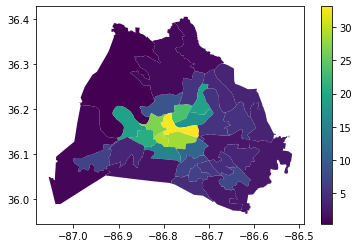

In [16]:
# Simple plot of building permit_density
districts_and_permits.plot(column = 'permit_density', legend = True);
plt.show();

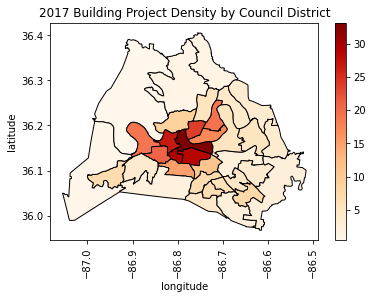

In [17]:
# Polished choropleth of building permit_density
districts_and_permits.plot(column = 'permit_density', cmap = 'OrRd',edgecolor = 'black', legend = True)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.xticks(rotation = 'vertical')
plt.title('2017 Building Project Density by Council District')
plt.show();

### choropleth with folium
- geo_data: the source data for the polygons
- name: the name of the geometry column (or geojson property) for the polygons
- data: the source DataFrame or Series for the normalized data
- columns: a list of columns, one that corresponds to the polygons and one that has the value to plot
- key_on: a geojson varible to bind the data to(always start with feature)
- fill_color: polygon fill color
- fill_opacity: 0(transparent) to 1(opaque)
- line_color: color of polygon border line
- line_opacity: range from 0 to 1
- legend_name: creates a title for the legend

In [21]:
# Center point for Nashville
nashville = [36.1636,-86.7823]

# Create map
m = folium.Map(location=nashville, zoom_start=10)

In [22]:
# Create center column for the centroid of each district
districts_and_permits['center'] = districts_and_permits.geometry.centroid

# Build markers and popups
for row in districts_and_permits.iterrows():
    row_values = row[1]
    center_point = row_values['center']
    location = [center_point.y, center_point.x]
    popup = ('Council District: ' + str(row_values['district']) + 
             ';  ' + 'permits issued: ' + str(row_values['bldg_permits']))
    marker = folium.Marker(location = location, popup = popup)
    marker.add_to(m)
    
# Display the map
display(m)

Use the school and school_district data

Text(20.75, 0.5, 'latitude')

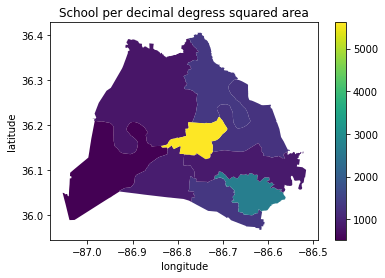

In [179]:
districts_with_counts.plot(column='school_density',legend=True)
plt.title('School per decimal degress squared area')
plt.xlabel('longitude')
plt.ylabel('latitude')

Text(20.75, 0.5, 'latitude')

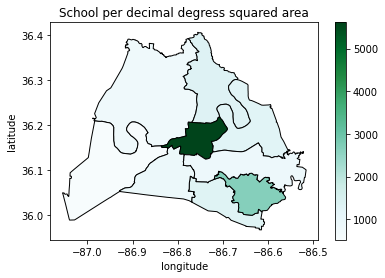

In [180]:
districts_with_counts.plot(column='school_density',cmap='BuGn',
                           edgecolor='Black',legend=True)
plt.title('School per decimal degress squared area')
plt.xlabel('longitude')
plt.ylabel('latitude')

In [181]:
print(school_districts.crs)

epsg:4326


Area of square kilometers is easier to interpret than decimal degrees squared

In [191]:
school_districts=school_districts.to_crs(epsg=3857)
print(school_districts.crs)
school_districts['area']=school_districts.geometry.area/sqm_to_sqkm
school_districts.head(2)

epsg:3857


,first_name,city,zip,email,state,last_name,address,position,term_expir,district,phone,geometry,center,area
0,Dr. Sharon,Nashville,37218,gentryfordistrict1@comcast.net,TN,Gentry,6108 Beals Lane,Member,2016,1,615-268-5269,"MULTIPOLYGON (((-9659344.056 4353528.767, -965...",POINT (-86.86087 36.26282),563.134380
1,Jill,Madison,37115,jill.speering@mnps.org,TN,Speering,1033 Falls Avenue,Vice-Chair,2016,3,615-562-5234,"MULTIPOLYGON (((-9657371.823 4356392.677, -965...",POINT (-86.72361 36.28516),218.369949


In [192]:
school_districts=school_districts.to_crs(epsg=4326)
school_districts.head(2)

,first_name,city,zip,email,state,last_name,address,position,term_expir,district,phone,geometry,center,area
0,Dr. Sharon,Nashville,37218,gentryfordistrict1@comcast.net,TN,Gentry,6108 Beals Lane,Member,2016,1,615-268-5269,"MULTIPOLYGON (((-86.77136 36.38357, -86.77134 ...",POINT (-86.86087 36.26282),563.134380
1,Jill,Madison,37115,jill.speering@mnps.org,TN,Speering,1033 Falls Avenue,Vice-Chair,2016,3,615-562-5234,"MULTIPOLYGON (((-86.75365 36.40428, -86.75353 ...",POINT (-86.72361 36.28516),218.369949


In [193]:
schools_in_districts = gpd.sjoin(school_districts,schools_geo, op = 'contains')
school_counts = schools_in_districts.groupby(['district']).size()
print(school_counts)
school_counts_df = school_counts.to_frame()
school_counts_df.reset_index(inplace=True)
school_counts_df.columns = ['district','school_count']

district
1    30
2    11
3    19
4    18
5    36
6    21
7    13
8    10
9    12
dtype: int64


In [194]:
districts_with_counts = pd.merge(school_districts,school_counts_df, on = 'district')
districts_with_counts.head(2)
districts_with_counts['school_density'] = districts_with_counts.apply(
lambda row:row.school_count/row.area, axis =1)
districts_with_counts.head(2)

,first_name,city,zip,email,state,last_name,address,position,term_expir,district,phone,geometry,center,area,school_count,school_density
0,Dr. Sharon,Nashville,37218,gentryfordistrict1@comcast.net,TN,Gentry,6108 Beals Lane,Member,2016,1,615-268-5269,"MULTIPOLYGON (((-86.77136 36.38357, -86.77134 ...",POINT (-86.86087 36.26282),563.134380,30,0.053273
1,Jill,Madison,37115,jill.speering@mnps.org,TN,Speering,1033 Falls Avenue,Vice-Chair,2016,3,615-562-5234,"MULTIPOLYGON (((-86.75365 36.40428, -86.75353 ...",POINT (-86.72361 36.28516),218.369949,19,0.087008


Text(20.75, 0.5, 'latitude')

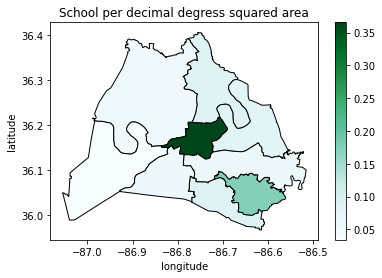

In [195]:
districts_with_counts.plot(column='school_density',cmap='BuGn',
                           edgecolor='Black',legend=True)
plt.title('School per kilometers squared')
plt.xlabel('longitude')
plt.ylabel('latitude')